In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from tqdm.notebook import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
metrics = at.load_roi_metrics(add_columns=True, remove_invalid=True, remove_duplicates=True)
metrics = metrics[(metrics.mouse == 409828) & (metrics.column == 1)]
metrics

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_mean,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_11_1_89,409828,1,1,1,89,True,False,False,0,NaN,...,0.000287,0.001903,0,0,1-1,False,False,-0.043955,30.681108,69.313722
M409828_11_2_0,409828,1,1,2,0,True,False,True,2,"M409828_11_2_0, M409828_11_3_2",...,0.000346,0.002629,0,0,1-2,False,False,-0.073683,61.781378,43.508462
M409828_11_2_1,409828,1,1,2,1,True,False,True,2,"M409828_11_2_1, M409828_11_3_0",...,0.000341,0.002262,0,0,1-2,True,True,-0.011145,20.539986,13.115250
M409828_11_2_2,409828,1,1,2,2,True,False,False,0,NaN,...,0.000341,0.002412,0,0,1-2,True,True,0.278888,360.000000,66.145993
M409828_11_2_4,409828,1,1,2,4,True,False,False,0,NaN,...,0.000234,0.001601,0,0,1-2,False,False,-0.100974,348.754021,307.709808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_1f_1_67,409828,1,f,1,67,True,False,False,0,NaN,...,0.001101,0.007307,10,700,f-1,False,False,0.126505,149.640456,37.085351
M409828_1f_1_69,409828,1,f,1,69,True,False,False,0,NaN,...,0.001627,0.010508,10,700,f-1,False,False,0.331093,186.314212,314.004962
M409828_1f_1_70,409828,1,f,1,70,True,False,False,0,NaN,...,0.001108,0.006967,10,700,f-1,False,True,-0.425755,214.434681,325.832316
M409828_1f_1_74,409828,1,f,1,74,True,False,False,0,NaN,...,0.000818,0.005215,10,700,f-1,False,False,-0.217209,141.171582,130.039470


<Axes: xlabel='dgf_pref_dir', ylabel='ssi'>

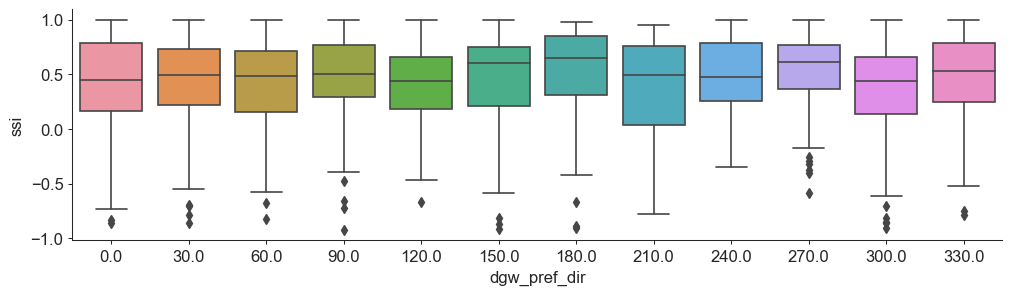

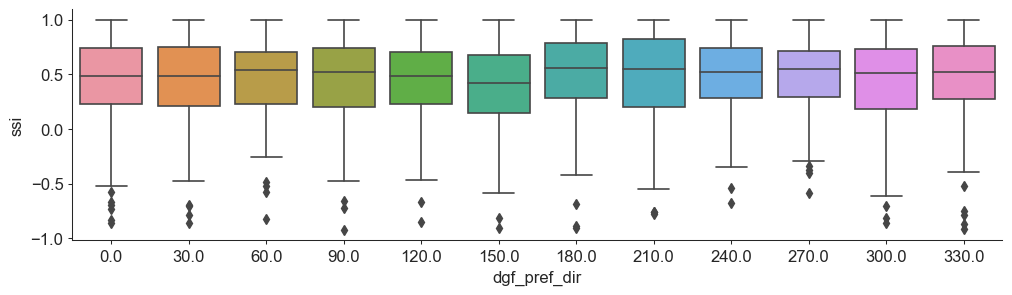

In [24]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=metrics[metrics.dgw_is_responsive], x="dgw_pref_dir", y="ssi")
plt.figure(figsize=(12, 3))
sns.boxplot(data=metrics[metrics.dgw_is_responsive], x="dgf_pref_dir", y="ssi")

Text(99.41666666666667, 0.5, 'DGW pref dir')

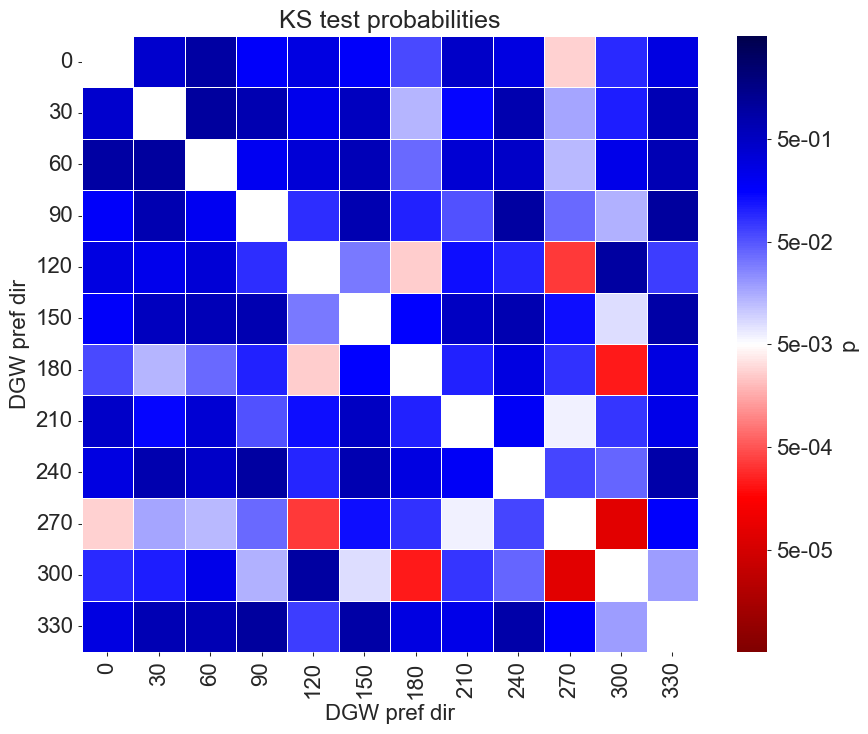

In [22]:
p_matrix = np.zeros((12, 12))
dirs = np.arange(0, 360, 30)

for i, dir_1 in enumerate(dirs):
    ssi_1 = metrics.ssi.values[metrics.dgw_is_responsive & (metrics.dgw_pref_dir == dir_1)]
    p_matrix[i, i] = np.nan
    
    for j in range(i+1, len(dirs)):
        dir_2 = dirs[j]
        ssi_2 = metrics.ssi.values[metrics.dgw_is_responsive & (metrics.dgw_pref_dir == dir_2)]
        _, p = scipy.stats.kstest(ssi_1, ssi_2)
        p_matrix[i, j] = p_matrix[j, i] = p
        

at.heatmap_log_proba_plot(p_matrix, ticklabels=dirs, title="KS test probabilities")
plt.xlabel("DGW pref dir", fontsize=16)
plt.ylabel("DGW pref dir", fontsize=16)